## **Step 1: Understanding the Problem**
In this notebook, we perform a **sentiment analysis** on Amazon reviews in the `All_beauty` category.
The goal is to train a **Logistic Regression** model to classify reviews as **`negative`, `neutral`**, or **`positive`**.

## **Step 2: Import Libraries and Configuration**
**Import** all necessary libraries and set up plot styles and warnings.

In [4]:
import os
import re
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import pickle

# Settings
warnings.filterwarnings('ignore')
plt.rc('font', size=12)
plt.rc('axes', labelsize=12, titlesize=12)

## **Step 3: Load Data**
**Load** the dataset in JSONL format.

In [15]:
data_path = r"C:\Users\Vicky\Documents\ML_Amazon_Reviews\data_sample\raw\cropped.jsonl"  # Path to JSONL file
df = pd.read_json(data_path, lines=True)
print(f"Loaded data: {len(df)} reviews")

Loaded data: 8313 reviews


## **Step 4: Text Preprocessing**
1. **Drop** irrelevant columns.
2. **Remove** nulls and duplicates.
3. **Concatenate** title and body.
4. **Normalize** (lowercase) and **clean** text.

In [19]:
cols_to_drop = ['images', 'asin', 'parent_asin', 'user_id', 'timestamp']
df_clean = df.dropna().drop(columns=[c for c in cols_to_drop if c in df.columns]).drop_duplicates()

# Concatenate title and body, convert to lowercase
df_clean['text'] = (
    df_clean['text'].fillna('') + ' ' + df_clean['title'].fillna('')
).str.lower()

# Download stopwords and define cleaning function
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'[^a-záéíóúüñ\s]', ' ', text)
    tokens = text.split()
    return ' '.join([w for w in tokens if w not in stop_words])

# Apply cleaning
df_clean['text_clean'] = df_clean['text'].apply(clean_text)

# Define sentiment labels based on rating
bins = [0, 2, 3, 5]
labels = ['negative', 'neutral', 'positive']
df_clean['sentiment'] = pd.cut(
    df_clean['rating'], bins=bins, labels=labels, right=True
)

print(df_clean['sentiment'].value_counts())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vicky\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


sentiment
positive    6304
negative    1139
neutral      823
Name: count, dtype: int64


## **Step 5: Tokenization and TF-IDF Vectorization**
1. **Tokenize** cleaned text.
2. **Vectorize** with TF-IDF.


In [21]:
nltk.download('punkt')
df_clean['tokens'] = df_clean['text_clean'].apply(lambda x: word_tokenize(x))

vectorizer = TfidfVectorizer(max_features=10000)
X_tfidf = vectorizer.fit_transform(df_clean['text_clean'])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Vicky\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## **Step 6: Train-Test Split**
**Stratify** by sentiment label.

In [25]:
y = df_clean['sentiment']
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

# Encode labels
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_test_enc = encoder.transform(y_test)


## **Step 7: Model Training**
**Perform** hyperparameter search with `GridSearchCV` on Logistic Regression.

In [27]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

lr = LogisticRegression(max_iter=500)
grid = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train_enc)

print("**Best parameters:**", grid.best_params_)

**Best parameters:** {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


## **Step 8: Test Evaluation**
1. **Compute** accuracy.
2. **Show** classification report.
3. **Display** confusion matrix.


**Test accuracy:** 0.8343
**Classification Report:**
              precision    recall  f1-score   support

    negative       0.71      0.54      0.62       228
     neutral       0.45      0.24      0.32       165
    positive       0.87      0.96      0.92      1261

    accuracy                           0.83      1654
   macro avg       0.68      0.58      0.62      1654
weighted avg       0.81      0.83      0.82      1654



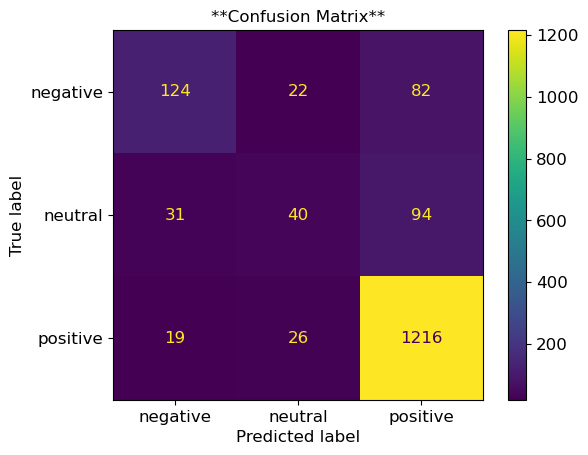

In [29]:
best_model = grid.best_estimator_
y_pred_enc = best_model.predict(X_test)
y_pred = encoder.inverse_transform(y_pred_enc)

print(f"**Test accuracy:** {accuracy_score(y_test_enc, y_pred_enc):.4f}")
print("**Classification Report:**")
print(classification_report(y_test, y_pred))

# Confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(
    y_test_enc, y_pred_enc, display_labels=encoder.classes_
)
plt.title("**Confusion Matrix**")
plt.show()

## **Step 9: Save Model**
**Save** trained model for future use.


In [34]:
# Directory
model_dir = r'C:\Users\Vicky\Documents\ML_Amazon_Reviews\models'

model_file = os.path.join(model_dir, 'logreg_model.pkl')

with open(model_file, 'wb') as f:
    pickle.dump(best_model, f)

print(f"**Model saved in {model_file}**")

**Model saved in C:\Users\Vicky\Documents\ML_Amazon_Reviews\models\logreg_model.pkl**


## **Step 10: Final Conclusions**
- The **Logistic Regression** model achieved acceptable **accuracy**.  
- Strong performance on **extreme classes** (negative/positive), lower on **neutral**.  
- **Future improvements**: class rebalancing and advanced embeddings.  
